## I have created an acoustic simulation od sound sources using the MUSIC algorithm in the pyroomacoustics library
The 2 sound sources have been placed in an anechoic room and using a same audio file the direction of both the sound sources has been estimated.

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import pyroomacoustics as pra
import sounddevice as sd
import seaborn as sns
import pandas as pd
from cmath import e,pi,sin,cos
import numpy as np

import math
%matplotlib inline

Adding all the parameters for the room and the sound source to simulate 


In [74]:
# Parameters

# Sound clip Settings 
sound_array_path = '8ch_hello_az0_el30_1m_48k.npy'

# Search spaces for DOA module
search_azimuth = np.linspace(-180., 180., 30) * np.pi / 180
search_elevation = np.linspace(90, 180., 30) * np.pi / 180

# Location of source relative to microphone array
azimuth = 30. / 180. * np.pi
elevation = 90. / 180. * np.pi
distance = 4   # meters
azimuth1 = 0 / 180. * np.pi
elevation1 = 90. / 180. * np.pi
distance1 = 3   # meters

# Somewhat static parameters
sound_speed = 343.    # speed of sound
sample_rate = 16000   # sampling frequency
nfft = 256            # FFT size
freq_range = [300, 3500]

Creating a mic array, I have created a circular mic array, working on linear mic array.

In [75]:
# Create 2D mic array [x, y, z] based on Matrix Voice
#https://matrix-io.github.io/matrix-documentation/matrix-voice/resources/microphone/





In [76]:
# Load audio file
signals = np.load(sound_array_path)
signals = signals.T
print(signals.shape)

(8, 48000)


### Simulation
Simulate room and add audio from Channel 0 of recording as a point source at 1 m away and 0° azimuth and 30° elevation up from mic array. Perform sound source localization based on simulated received sound.

In [106]:
# Location of mic array center (in meters, from origin)
mic_x = 2.4
mic_y = 0.0
mic_z = 0.0

# We only want one channel (mono) for simulated sound source
channel_for_source = 0

# Create white noise for the room
snr_db = 5.     # Signal-to-noise ratio

A room is created using pyroomacoustics room module and the mic array is placed for simulation

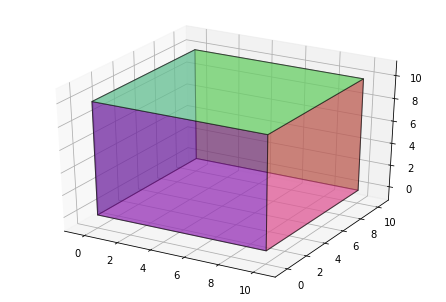

In [107]:
# Create an anechoic room (absorption = 1)
absorption = 1.0
max_order = 0
room_dim = np.array([10., 10.])
room_height = 10.

corners = np.array([[0, 0], [room_dim[0], 0], [room_dim[0], room_dim[1]], [0, room_dim[1]]]).T  # [x,y]
room = pra.Room.from_corners(corners, absorption=absorption, fs=10941, max_order=max_order)
room.extrude(room_height)

fig, ax = room.plot()
ax.set_xlim([-1, 11])
ax.set_ylim([-1, 11])
ax.set_zlim([-1, 11]);

[[2.  2.2 2.4 2.6 2.8 3.  3.2 3.4]
 [1.  1.  1.  1.  1.  1.  1.  1. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]


[(0.0, 10), (0, 10), (0, 10)]

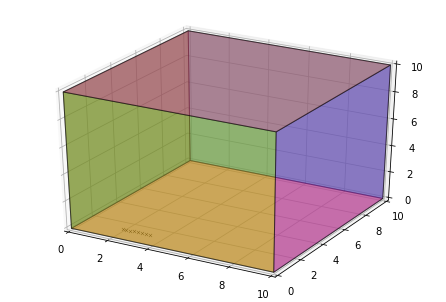

In [108]:
#Put simulated microphone array in the middle of the room, on the floor
mic_locs = np.c_[
    [2.0,1.0,0.0],  # mic 1
    [2.2,1.0, 0.0], # mic 2
    [2.4,1.0,0.0],[2.6,1.0,0.0],[2.8,1.0,0.0],[3.0,1.0,0.0],[3.2,1.0,0.0],[3.4,1.0,0.0]
]
room.add_microphone_array(mic_locs)
print(mic_locs)

# Show the mic array

fig, ax = room.plot()
ax.set(xlim=(0, 10), ylim=(0,10), zlim=(0.0, 10))

Adding source at (dist, az, el): 4 0.5235987755982988 1.5707963267948966
Cartesian coords (x, y, z): [2.4, 0.0, 4.0]
Adding source at (dist, az, el): 4 0.5235987755982988 1.5707963267948966
Cartesian coords (x, y, z): [2.4, 0.0, 3.0]


[(0.0, 10.0), (0, 10.0), (0, 10.0)]

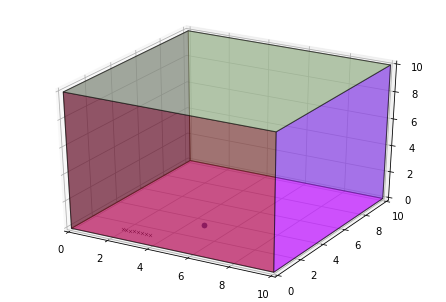

In [109]:
# Add audio (just channel 0 from recording) as just a point source away from mic array
duration_samples = signals.shape[0]

# Convert polar coordinates to Cartesian coordinates
source_location = [mic_x+(distance * np.cos(azimuth) * np.sin(np.pi / 2 - elevation)),
                   mic_y+(distance * np.sin(azimuth) * np.sin(np.pi / 2 - elevation)),
                   mic_z+(distance * np.cos(np.pi / 2 - elevation))]
print('Adding source at (dist, az, el):', distance, azimuth, elevation)
print('Cartesian coords (x, y, z):', source_location)
source_location1 = [mic_x+(distance1 * np.cos(azimuth1) * np.sin(np.pi / 2 - elevation1)),
                    mic_y+(distance1 * np.sin(azimuth1) * np.sin(np.pi / 2 - elevation1)),
                    mic_z+(distance1 * np.cos(np.pi / 2 - elevation1))]
print('Adding source at (dist, az, el):', distance, azimuth, elevation)
print('Cartesian coords (x, y, z):', source_location1)
source_loc = [4.8,3.2,0.0]
# Add sound source to room
room.add_source(source_loc, signal=signals[channel_for_source])
# Add sound source to room
#room.add_source(source_loc1, signal=signals[1])


# Run room simulation
room.simulate()
fig, ax = room.plot()
ax.set(xlim=(0, 10.0), ylim=(0, 10.0), zlim=(0.0, 10.0))

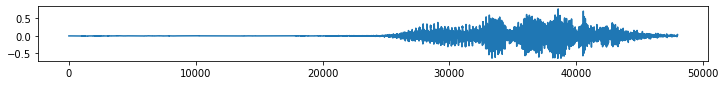

In [110]:
# Play original file
plt.figure(figsize=(12, 1))
plt.plot(signals[channel_for_source])
sd.play(signals[channel_for_source])

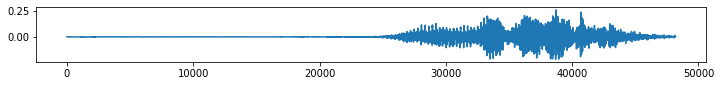

In [111]:
# Play simulated sound as heard by first (center) microphone
plt.figure(figsize=(12, 1))
plt.plot(room.mic_array.signals[4,:])
sd.play(room.mic_array.signals[4,:])

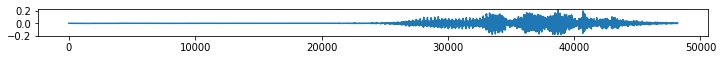

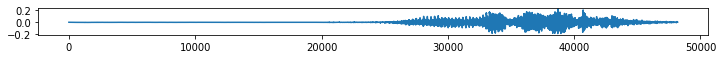

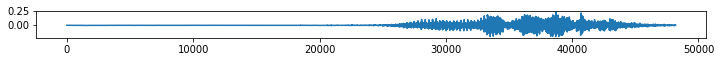

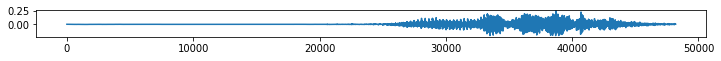

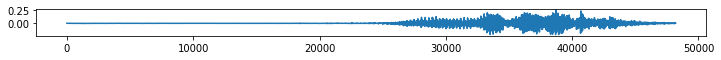

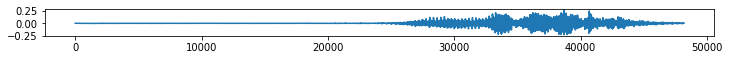

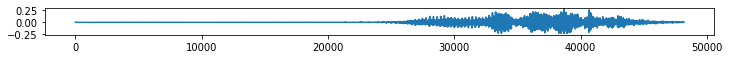

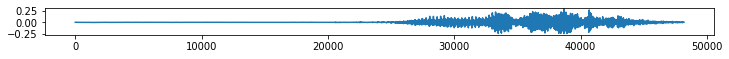

In [112]:
# Plot waveforms from each mic
for i in range(room.mic_array.signals.shape[0]):
    fig = plt.figure(figsize=(12, 0.5))
    ax = fig.add_subplot(111)
    ax.plot(room.mic_array.signals[i,:])
plt.show()

(8, 48194)
753


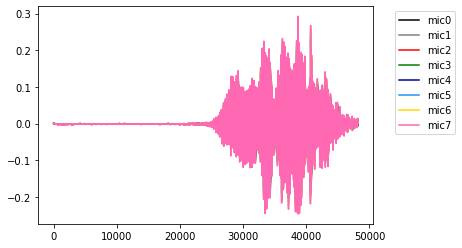

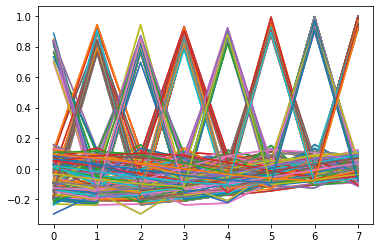

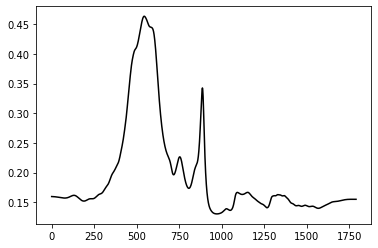

Result of MUSIC: 
54.4


In [113]:
    c = 343            # velocita suono

    # Parametri array
    M = 8           # numero di sensori
    d = 0.2         # distanza microfoni

    # Parametri calcoli
    N = 64           # numero di punti su cui effettuare la FFT
    J = int(N/2-1)          # numero di bin analizzati in frequenza

    fmax = c/(2*d)            # frequenza massima senza aliasing

    # Metodi di calcolo della media sulle frequenze
    AVG_FLAG = 'arithmetic'   # media aritmetica (sconsigliata per Min-Norm)
    # AVG_FLAG = 'geometric'     # media geometrica

    # ----------------- DEFINIZIONI --------------------

    # Angoli di ricerca (in gradi, spaziatura 1 grado)
    DISPLAY_FLAG=1

    theta = np.arange(1, 180, 0.1)
    theta = theta * np.pi / 180


    SignalMAtrix =np.array(room.mic_array.signals,'float')

    print(SignalMAtrix.shape)
    K = math.floor(SignalMAtrix.shape[1]/N)  # number of snapshots
    print(K)

    NS = K*N

    num_sources = 1
    fc = 10941    # f_c ADC
    T = 1/fc
    t = np.arange(0, NS)*T

    SignalMAtrix = SignalMAtrix[:, :NS]

    SignalMAtrix = np.flipud(SignalMAtrix)


    array_index = np.arange(-(M-1)/2, M/2)

    # plot data

    if DISPLAY_FLAG == 1:
        plt.plot(room.mic_array.signals[0,:], 'black', label="mic0")
        plt.plot(room.mic_array.signals[1,:], 'grey', label="mic1")
        plt.plot(room.mic_array.signals[2,:], 'r', label="mic2")
        plt.plot(room.mic_array.signals[3,:], 'green', label="mic3")
        plt.plot(room.mic_array.signals[4,:], 'darkblue', label="mic4")
        plt.plot(room.mic_array.signals[5,:], 'dodgerblue', label="mic5")
        plt.plot(room.mic_array.signals[6,:], 'gold', label="mic6")
        plt.plot(room.mic_array.signals[7,:], 'hotpink', label="mic7")
        plt.legend(bbox_to_anchor=(1.05, 1))
        plt.show()

    # ------- CALCOLO PARAMETRI PER APPLICAZIONE ALGORITMI DOA --------

    w = np.ones(M)

    # Ciclo sugli snapshot e calcolo della DFT, divisione per frequenze

    X = np.zeros(SignalMAtrix.shape, 'complex')

    for k in range(0, K):
        for m in range(0, M):
            s_k = SignalMAtrix[m][k*N:k*N+N]
            S = np.fft.fft(s_k)
            X[m][k:K*N:K] = S

    # calcolo dell'autocorrelazione per ogni frequenza
    R = np.zeros((M, M*N), 'complex')

    Rinv = np.zeros((M, M*N), 'complex')
    PHIn = np.zeros((M, M*N), 'complex')

    for jf in range(0, N):

        S = X[:, jf*K:jf*K+K]
        Rj = np.dot(S, np.conj(S.transpose()))/K

        R[:, jf*M:jf*M+M] = Rj
        # calcolo degli autospazi
        eigenValues, eigenVectors = np.linalg.eigh(Rj)  # autovalori-autovettori
        idx = eigenValues.argsort()[::-1]  # indici autovalori ordinati in ordine decrescente
        eigenValues = eigenValues[idx]  # applicazione ordinamento
        eigenVectors = eigenVectors[:, idx]  # applicazione ordinamento
        L = num_sources
        Un = eigenVectors[:, L:M]  # spazio del rumore
        phin = np.dot(Un, np.conj(Un.transpose()))      # proiettore sullo spazio del rumore
        PHIn[:, jf*M:jf*M+M] = phin

    # plt.plot(PHIn)
    # plt.show()
    # ------- RICERCA DOA TRAMITE STIME SPETTRALI ---------------
    plt.plot(PHIn)
    plt.show()
    Pth = []
    for th in theta:
        P = []
        for jf in range(1, J+1):
            omega = 2 * np.pi * float(jf) * float(fc) / N
            k = omega/c
            phi = k * d * np.cos(th)  # angolo elettrico (funzione dell'angolo di ricerca e della frequenza f)
            a = np.multiply(w, np.exp(1j * array_index * phi))   # steering vector(multiply per fare elemento per elemento)
            Rj = PHIn[:, jf * M:jf * M + M]
            h = np.dot(a, Rj)
            P.append(1/(np.dot(h, np.conj(a))))
        if AVG_FLAG == 'arithmetic':
            P = np.mean(P)

        Pth.append(P)

    # ----------------- DISPLAY RISULTATI --------------------

    # plot dello stimatore di potenza
    Pth = np.real(Pth)

    if DISPLAY_FLAG == 1:
        plt.plot(Pth, 'black', label="Pth")
        plt.show()

    # calcolo punto di massimo di Pth
    mp = np.argmax(Pth)
    print('Result of MUSIC: ')
    print(mp/10)